In [165]:
#import Libs and check versions

import sys
import nltk
import sklearn
import pandas
import numpy

print('Python: {}'.format(sys.version))
print('NLTK: {}'.format(nltk.__version__))
print('Scikit-learn: {}'.format(sklearn.__version__))
print('Pandas: {}'.format(pandas.__version__))
print('Numpy: {}'.format(numpy.__version__))

Python: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
NLTK: 3.4.5
Scikit-learn: 0.21.3
Pandas: 0.25.1
Numpy: 1.16.5


In [166]:
import warnings
warnings.filterwarnings("ignore")

# LOAD DATASET

In [1]:
#dataframe packages
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)


In [2]:
#model packages
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

In [3]:
#read datasets
df=pd.read_csv('bank_sentimental_data.csv',encoding = 'ISO-8859-1',header=None)


In [4]:
#read 5 lines
df.head()

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
#rename the columns
df.columns = ['Class', 'text_heading']

In [6]:
#confirm labels
df.head(10)

,Class,text_heading
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,positive,"For the last quarter of 2010 , Componenta 's n..."
7,positive,"In the third quarter of 2010 , net sales incre..."
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...
9,positive,"Operating profit totalled EUR 21.1 mn , up fro..."


In [7]:
#view data info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
Class           4846 non-null object
text_heading    4846 non-null object
dtypes: object(2)
memory usage: 75.8+ KB
None


# EXPLORATORY DATA ANALYSIS

In [174]:
#Analysis of class distibution
print(df.Class.value_counts(normalize=True)*100)

neutral     59.409823
positive    28.126290
negative    12.463888
Name: Class, dtype: float64


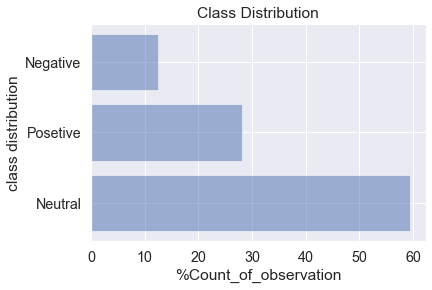

In [340]:
#Analysis of class % distibution-Graph
x_class=('Neutral','Posetive','Negative')
pct_count=[59.41,28.13,12.46]
y_pos = np.arange(len(x_class))
plt.barh(y_pos, pct_count, align='center', alpha=0.5)
plt.yticks(y_pos, x_class)
plt.ylabel('class distribution')
plt.xlabel('%Count_of_observation')
plt.title('Class Distribution')
plt.show()

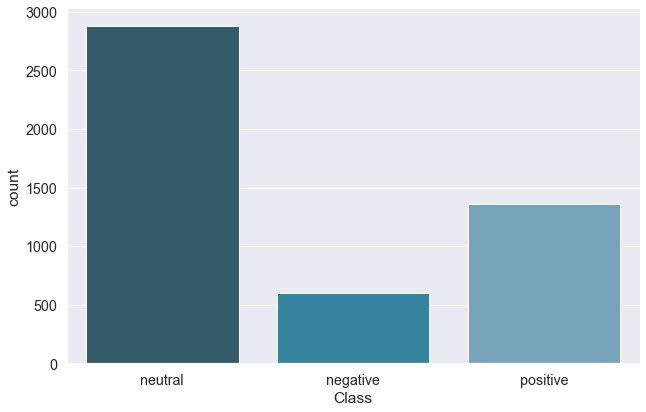

In [176]:
#plot by word count
sns.factorplot(x="Class", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [177]:
#words count distribution excluding white space

df['body_len']=df['text_heading'].apply(lambda x: len(x)-x.count(" "))
df.head()


,Class,text_heading,body_len
0,neutral,"According to Gran , the company has no plans t...",103
1,neutral,Technopolis plans to develop in stages an area...,160
2,negative,The international electronic industry company ...,193
3,positive,With the new production plant the company woul...,174
4,positive,According to the company 's updated strategy f...,163


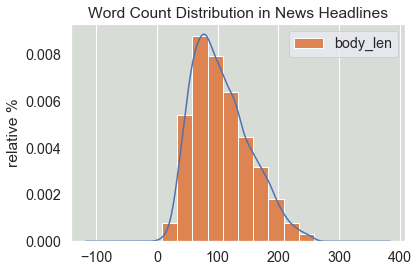

In [178]:
fig, ax = plt.subplots()
df.plot.kde(ax=ax, legend=False, title='Word Count Distribution in News Headlines')
df.plot.hist(density=True, ax=ax)
ax.set_ylabel('relative %')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

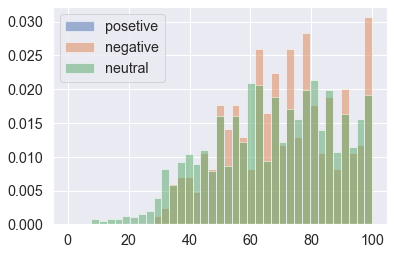

In [179]:
#words count distribution -plot
bins=np.linspace(0,100,40)
plt.hist(df[df['Class']=='posetive']['body_len'],bins,alpha=0.5,normed=True,label='posetive')
plt.hist(df[df['Class']=='negative']['body_len'],bins,alpha=0.5,normed=True,label='negative')
plt.hist(df[df['Class']=='neutral']['body_len'],bins,alpha=0.5,normed=True,label='neutral')
plt.legend(loc='upper left')
plt.show()

# PREPROCESS THE DATA

In [180]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
classes=df.Class
Y=encoder.fit_transform(classes)
print(Y[:10])

[1 1 0 2 2 2 2 2 2 2]


In [181]:
# verify conversion
print(classes[:10])

0     neutral
1     neutral
2    negative
3    positive
4    positive
5    positive
6    positive
7    positive
8    positive
9    positive
Name: Class, dtype: object


In [220]:
#store text_headin in text
text=df.text_heading
print(text[:5])

0    According to Gran , the company has no plans t...
1    Technopolis plans to develop in stages an area...
2    The international electronic industry company ...
3    With the new production plant the company woul...
4    According to the company 's updated strategy f...
Name: text_heading, dtype: object


In [221]:
#replace and specific figure amounts  with $, change to money
processed=text.str.replace(r'^\$?(\d{1,3}(\,\d{3})*|(\d+))(\.\d{0,2})?$','money')
print(processed[:5])

#replace phone numbers in heading text with phone

processed=processed.str.replace(r'^(\(?\+?[0-9]*\)?)?[0-9_\- \(\)]*$','phone number')
print(processed[:5])


#replace 4  fig to year
processed=processed.str.replace(r'^\d{4}s*$','year')
print(processed[:10])

# replace any percentage figure to percent
processed=processed.str.replace(r'^\d{0,2}(\.\d{1,4})? *%?$','percent')
print(processed[:5])

#change EUR/eur to read as money symbol
processed=processed.str.replace(r'EUR|\s*$','money')
print(processed[:50])

#change % to percent
processed=processed.str.replace(r'^\s*(\d{0,2})(\.?(\d*))?\s*\%?\s*$','percent')
print(processed[:50])

#replace remaining numbers to figure
processed=processed.str.replace(r'\d+(\.\d+)?','figure')
print(processed[:5])


0    According to Gran , the company has no plans t...
1    Technopolis plans to develop in stages an area...
2    The international electronic industry company ...
3    With the new production plant the company woul...
4    According to the company 's updated strategy f...
Name: text_heading, dtype: object
0    According to Gran , the company has no plans t...
1    Technopolis plans to develop in stages an area...
2    The international electronic industry company ...
3    With the new production plant the company woul...
4    According to the company 's updated strategy f...
Name: text_heading, dtype: object
0    According to Gran , the company has no plans t...
1    Technopolis plans to develop in stages an area...
2    The international electronic industry company ...
3    With the new production plant the company woul...
4    According to the company 's updated strategy f...
5    FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6    For the last quarter of 2010 , Componenta 's n.

In [225]:
#replace remaining numbers to figure
processed=processed.str.replace(r'\d+(\.\d+)?','figure')
print(processed[:5])

0    According to Gran , the company has no plans t...
1    Technopolis plans to develop in stages an area...
2    The international electronic industry company ...
3    With the new production plant the company woul...
4    According to the company 's updated strategy f...
Name: text_heading, dtype: object


In [226]:
#change EUR/eur to read as money symbol
processed=processed.str.replace(r'%|\s*$','percent')
print(processed[:5])

0    According to Gran , the company has no plans t...
1    Technopolis plans to develop in stages an area...
2    The international electronic industry company ...
3    With the new production plant the company woul...
4    According to the company 's updated strategy f...
Name: text_heading, dtype: object


In [227]:
#replace remaining numbers to figure
processed=processed.str.replace(r'\d+(\.\d+)?','figure')
print(processed[:5])

0    According to Gran , the company has no plans t...
1    Technopolis plans to develop in stages an area...
2    The international electronic industry company ...
3    With the new production plant the company woul...
4    According to the company 's updated strategy f...
Name: text_heading, dtype: object


In [262]:
#import NLTK packages
import re
import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [263]:
#remove stopwords, lemmatize and stem
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lem = WordNetLemmatizer()

In [264]:
corpus = []
for text in processed:
    text = text.lower() #changes everything lower case
    nopunct_text = re.sub('[^a-z0-9]',' ',text) #remove non alphanumeric characters
    #tokenize 
    tokens = WhitespaceTokenizer().tokenize(nopunct_text)
    filtered = [ps.stem(lem.lemmatize(w)) for w in tokens if w not in stop_words] 
    filtered_text = ' '.join(filtered)
    corpus.append(filtered_text)

In [265]:
print(corpus)

['accord gran compani plan move product russia although compani grow moneyperc', 'technopoli plan develop stage area le figurefigur squar meter order host compani work comput technolog telecommun statement said moneyperc', 'intern electron industri compani elcoteq laid ten employ tallinn facil contrari earlier layoff compani contract rank offic worker daili postim report moneyperc', 'new product plant compani would increa capac meet expect increa demand would improv use raw materi therefor increa product profit moneyperc', 'accord compani updat strategi year figurefigur baswar target longterm net sale growth rang figur percent figur percent oper profit margin figur percent figur percent net sale moneyperc', 'financ aspocomp growth aspocomp aggress pursu growth strategi increasingli focu technolog demand hdi print circuit board pcb moneyperc', 'last quarter figur componenta net sale doubl moneyfigurem moneyfigurem period year earlier move zero pretax profit pretax loss moneyfigurem mone

In [297]:
# check if data is well cleaned

#remove pancuation
processed=processed.str.replace(r'[^\w\d\s]','')
print(processed)

#remove white space
processed=processed.str.replace(r'\s+',' ')

#remove leading space &trailing  space
processed=processed.str.replace(r'^\s+|\s+?$','')

#change to lower case
processed=processed.str.lower()

#remove stopwords, lemmatize and stem
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lem = WordNetLemmatizer()
processed=processed.apply(lambda x:' '.join(term for term in x.split() if term not in stop_words))
#remove word stems
processed=processed.apply(lambda x:' '.join(ps.stem(term) for term in x.split()))

0       accord gran compani plan move product russia a...
1       technopoli plan develop stage area less figure...
2       intern electron industri compani elcoteq laid ...
3       new product plant compani would increas capac ...
4       accord compani updat strategi year figurefigur...
                              ...                        
4841    london marketwatch share price end lower londo...
4842    rinkuskiai beer sale fell figur per cent figur...
4843    oper profit fell money figur mn money figur mn...
4844    net sale paper segment decreas money figur mn ...
4845    sale finland decreas figur percent januari sal...
Name: text_heading, Length: 4846, dtype: object


In [268]:
y = df.Class

In [269]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()


In [270]:
# run kfold for all the selected models

from sklearn.model_selection import train_test_split
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus,y,random_state=0)

In [271]:
X_train = cv.fit_transform(corpus_train).toarray()
X_test = cv.transform(corpus_test).toarray()

In [272]:
word_indices = cv.vocabulary_

In [283]:
#transform processed text heading  into a vesctor list
X=cv.transform(processed)


In [294]:
print(word_indices)[10]

{'employ': 1511, 'leav': 2911, 'compani': 966, 'within': 6081, 'durat': 1408, 'cover': 1098, 'money': 3388, 'invest': 2523, 'ensur': 1543, 'commit': 961, 'return': 4529, 'moneyperc': 3394, 'howev': 2316, 'net': 3525, 'sale': 4676, 'figur': 1753, 'seen': 4804, 'grown': 2118, 'moneyfigur': 3389, 'pretax': 4174, 'profit': 4214, 'group': 2115, 'life': 2956, 'insur': 2474, 'busi': 690, 'increa': 2412, 'moneyfigurem': 3392, 'section': 4796, 'also': 177, 'includ': 2407, 'ahlstrom': 118, 'sustain': 5316, 'report': 4481, 'fortum': 1909, 'expect': 1658, 'annual': 233, 'capit': 736, 'expenditur': 1660, 'next': 3556, 'four': 1918, 'five': 1852, 'year': 6153, 'rang': 4338, 'figurefigur': 1761, 'billion': 529, 'earlier': 1420, 'announc': 232, 'term': 5467, 'agreement': 114, 'bung': 684, 'acquir': 43, 'raisio': 4327, 'keiju': 2716, 'makuisa': 3115, 'pyszni': 4277, 'duet': 1406, 'brand': 625, 'manufactur': 3141, 'plant': 4053, 'finland': 1826, 'poland': 4092, 'furthermor': 1983, 'novat': 3647, 'oy': 3

TypeError: 'NoneType' object is not subscriptable

In [321]:
#create bag of words
from nltk.tokenize import word_tokenize
all_words=[]
for message in processed:
    words=word_tokenize(message)
    for w in words:
        all_words.append(w)
        
print(all_words[:15])

['accord', 'gran', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'compani', 'grow', 'moneyperc', 'technopoli', 'plan', 'develop', 'stage']


In [322]:
#print most common words and number of words 
all_words=nltk.FreqDist(all_words)
print('number of words:{}'.format(len(all_words)))
print('most common words:{}'.format(all_words.most_common(10)))

number of words:7235
most common words:[('figur', 5215), ('moneyperc', 4794), ('compani', 971), ('money', 928), ('oper', 571), ('percent', 568), ('said', 544), ('mn', 515), ('finnish', 513), ('sale', 501)]


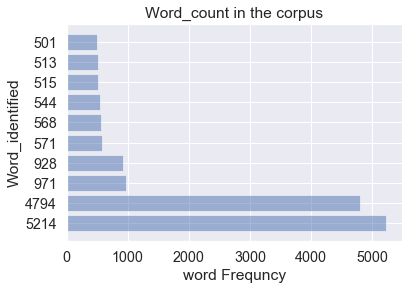

In [323]:
#MOST COMMON WORDS
words=('figur','moneyperc','compani','money','oper','percent','said','million','finnish','sale')
word_count=[5214,4794,971,928,571,568,544,515,513,501]
y_pos = np.arange(len(words))
plt.barh(y_pos, word_count, align='center', alpha=0.5)
plt.yticks(y_pos, word_count)
plt.ylabel('Word_identified')
plt.xlabel('word Frequncy')
plt.title('Word_count in the corpus')
plt.show()

In [324]:
word_features=list(all_words.keys())[:1500]
#define  feature function
def find_features(message):
    words=word_tokenize(message)
    features={}
    for word in word_features:
        features[word]=(word in words)
    return features

#see example
features=find_features(processed[0])
for key,value in features.items():
    if value==True:
        print(key)
        
# VERIFY FEATURES
features



#ZIP PROCESSED MESSAGES WITH Y LABEL
messages=list(zip(processed,Y))

#call find_featurs function for each message/heading
featuresets=[(find_features(text),label) for (text,label) in messages]

from sklearn import model_selection 
training,testing=model_selection.train_test_split(featuresets,test_size=0.25,random_state=seed)

print('training:{}'.format(len(training)))
print('testing:{}'.format(len(testing)))

accord
gran
compani
plan
move
product
russia
although
grow
moneyperc
training:3634
testing:1212


In [318]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

# KFOLD MODEL SCORE VALIDATION

In [319]:
# prepare models and run kfold-cv=10 for all models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='linear')))
models.append(('RFC', RandomForestClassifier()))
models.append(('SGD', SGDClassifier(max_iter=100)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X.toarray(), y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.647963 (0.194137)
LDA: 0.437261 (0.056827)
KNN: 0.595793 (0.267849)
CART: 0.599675 (0.190345)
NB: 0.432101 (0.064361)
SVM: 0.611855 (0.161638)
RFC: 0.619308 (0.239321)
SGD: 0.626281 (0.153528)


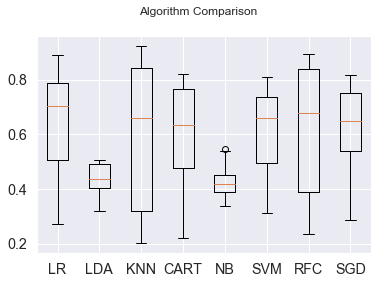

In [320]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# NLTK MODEL SCORE

In [304]:
#import classifiers
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.svm import SVC

In [333]:
names=['K Nearest Kneighbors','Random Forest','Logistic Regression','SGDClassifier',
       'Decision Tree','Naive Bayes','SVC']
classifiers=[
    KNeighborsClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter=100),
    DecisionTreeClassifier(),
    MultinomialNB(),
    SVC(kernel='linear')      
]

models=zip(names,classifiers)


In [334]:
#wrap models

from nltk.classify.scikitlearn import SklearnClassifier

for name,model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    nltk_model=SklearnClassifier(model)
    nltk_model.train(training)
    accuracy=nltk.classify.accuracy(nltk_model,testing)*100
    print('{}:Accuracy:{}'.format(name,accuracy))


K Nearest Kneighbors:Accuracy:64.68646864686468
Random Forest:Accuracy:69.3069306930693
Logistic Regression:Accuracy:71.94719471947195
SGDClassifier:Accuracy:69.55445544554455
Decision Tree:Accuracy:65.26402640264027
Naive Bayes:Accuracy:69.47194719471948
SVC:Accuracy:69.88448844884488


In [335]:
#create an ensemble method
from sklearn.ensemble import VotingClassifier
classifiers=[
    KNeighborsClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter=100),
    DecisionTreeClassifier(),
    MultinomialNB(),
    SVC(kernel='linear')
      
]

#define model to train
models=list(zip(names,classifiers))
nltk_ensemble=SklearnClassifier(VotingClassifier(estimators=models,voting='hard',n_jobs=-1))
nltk_ensemble.train(training)
accuracy=nltk.classify.accuracy(nltk_ensemble,testing)*100
print('Ensemle method Accuracy:{}'.format(accuracy))


Ensemle method Accuracy:72.52475247524752


In [336]:
#make class label prediction
txt_features,labels=zip(*testing)
prediction=nltk_ensemble.classify_many(txt_features)

In [339]:
#generate classification report
print(classification_report(labels,prediction))


              precision    recall  f1-score   support

           0       0.62      0.47      0.53       150
           1       0.74      0.89      0.81       709
           2       0.72      0.50      0.59       353

    accuracy                           0.73      1212
   macro avg       0.69      0.62      0.64      1212
weighted avg       0.72      0.73      0.71      1212



In [309]:
pd.DataFrame(confusion_matrix(labels,prediction),
             index=[['Actual','Actual','Actual'],['Posetive','Negative','Neutral']],
             columns=[['predicted','predicted','predicted'],['Posetive','Negative','Neutral']])

predicted                 
                 Posetive Negative Neutral
Actual Posetive        94       37       6
       Negative         7      683      14
       Neutral         14       77     280